# Análisis de variables macroeconómicas

In [62]:
# Importar paquetes requeridos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import statsmodels.formula.api as smf
plt.close('all')

# Configuración de los gráficos ('True' para alta resolución)
calidad_publicacion = False

if calidad_publicacion:
    matplotlib.rcParams['figure.dpi']= 300
else:
    matplotlib.rcParams['figure.dpi']= 60

%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-talk')

## El producto interno bruto en general

El primer análisis es el del producto interno bruto. Para ello empleamos la serie `pib_trimestral`, que contiene observaciones trimestrales del producto interno bruto a precios constantes (2013), desde el primer trimestre de 1993 hasta el tercer trimestre de 2020:

In [2]:
# Cargar base de datos del PIB
pib_trimestral = pd.read_excel('pib.xlsx', engine = 'openpyxl')
pib_trimestral = pib_trimestral.set_index('periodo')

pib_trimestral.head()

,trimestre,pib
periodo,,
1993,1,1.000889e+07
1993,2,1.017104e+07
1993,3,1.006626e+07
1993,4,1.041610e+07
1994,1,1.034339e+07


La serie `pib_trimestral` contiene observaciones del PIB trimestral *anualizado* de México. Esto quiere decir que cada observación se debe dividir por 4 para obtener el PIB del trimestre. Por tanto, para obtener el PIB anual se debe calcular el promedio de los correspondientes valores trimestrales. Esta nueva serie se llama `pib_anual`:

In [3]:
# Agrupar por periodo y calcular la media:
pib_anual = pib_trimestral.copy()
pib_anual = pib_anual.groupby('periodo')
pib_anual = pib_anual.mean()

# Eliminar la columna 'trimestre' que ya no es necesaria:
pib_anual.pop('trimestre')

pib_anual.head()

,pib
periodo,
1993,1.016557e+07
1994,1.066786e+07
1995,9.996721e+06
1996,1.067382e+07
1997,1.140465e+07


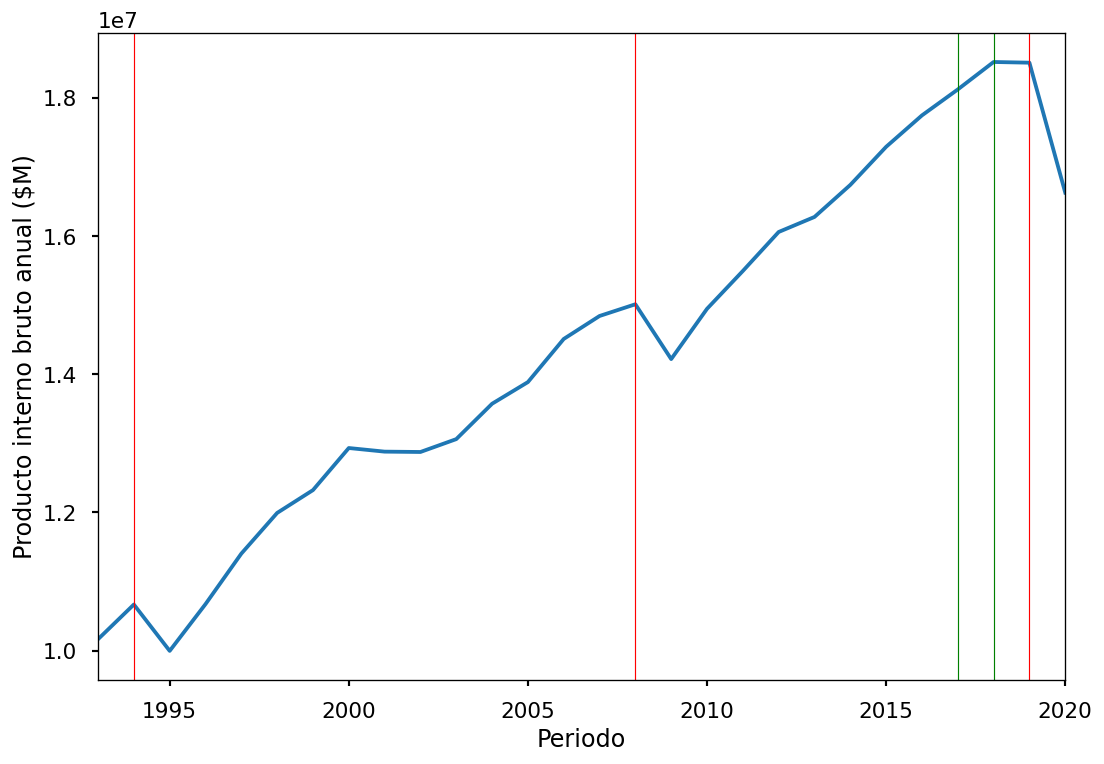

In [4]:
plt.plot(pib_anual['pib'])
plt.xlabel('Periodo')
plt.ylabel('Producto interno bruto anual ($M)')
plt.xlim(min(pib_anual.index),max(pib_anual.index))
plt.axvline(x = 1994, linewidth = '0.7', color = 'r') # 1994
plt.axvline(x = 2008, linewidth = '0.7', color = 'r') # 2008
plt.axvline(x = 2019, linewidth = '0.7', color = 'r') # 2019
plt.axvline(x = 2017, linewidth = '0.7', color = 'g') # Donald Trump (2017)
plt.axvline(x = 2018, linewidth = '0.7', color = 'g') # López Obrador (2018)

**Observaciones**:
* Hay tres caídas significativas del PIB anual, en los siguientes años: 1994 (crisis del tequila), 2008 (crisis financiera de EEUU) y 2019 (coronavirus).
* La magnitud de la recesión ocasionada por la pandemia del coronavirus es significativamente mayor que las otras dos.
* La recesión del coronavirus fue precedida por un periodo de crecimiento nulo (ligeramente negativo de hecho), que coincide con el inicio del gobierno actual (2018, segunda línea verde). Observamos que incluso después de la toma de posesión de Donald Trump (2017, primera línea verde), el país experimentó un crecimiento a la misma tasa media que los años anteriores.

En general, pensamos que el crecimiento del PIB guarda una correlación positiva con el crecimiento de la población. Por eso, para utilizar el PIB como una medida del crecimiento económico más objetiva es útil eliminar este efecto calculando el PIB per cápita (notamos que puede haber crecimiento de población y contracción del producto simultáneamente en el corto plazo).

Usaremos la serie `poblacion` que contiene información de la población de México registrada en los censos quinquenales:

(1910.0, 2015.0)

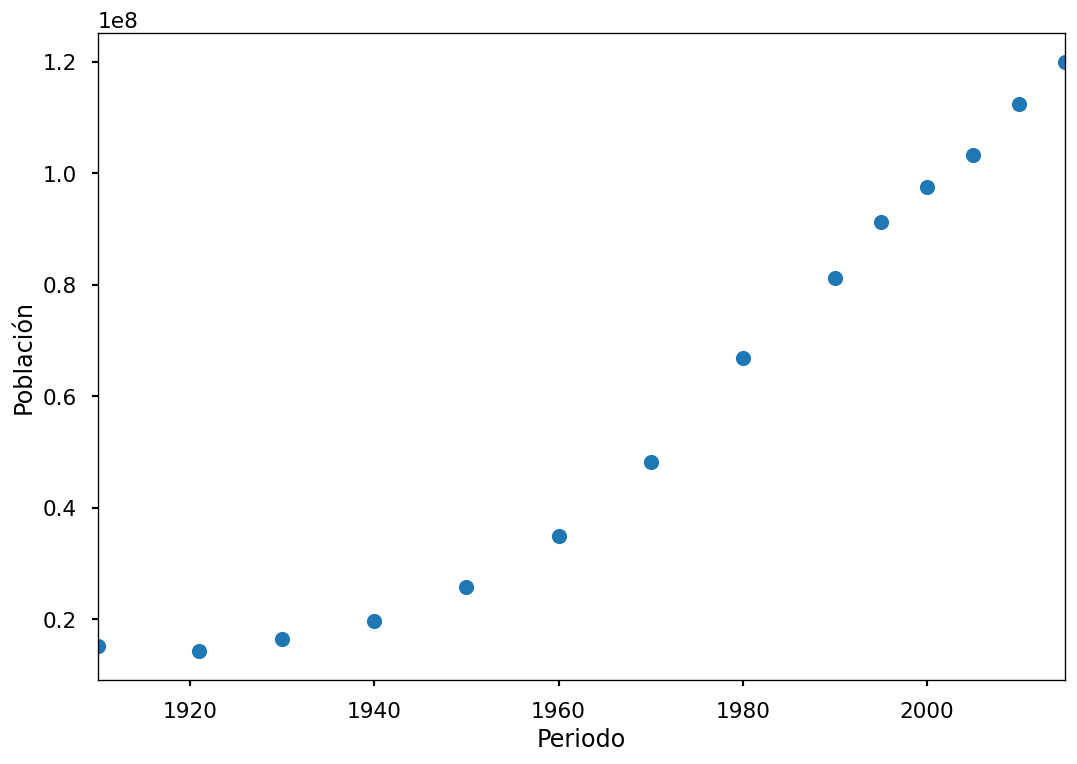

In [5]:
# Cargar base de datos de la población
poblacion = pd.read_excel('poblacion.xlsx', engine = 'openpyxl')
poblacion = poblacion.set_index('periodo')
plt.plot(poblacion['poblacion'], 'o')
plt.xlabel('Periodo')
plt.ylabel('Población')
plt.xlim(min(poblacion.index),max(poblacion.index))

Debido a que la información no es anual, es necesario estimar la población en los periodos intercensales. La forma más sencilla de hacerlo es mediante una estimación (interpolación) lineal entre los periodos censales. Dadas dos observaciones (en censos consecutivos) $p_t$ y $p_{t+k}$ de la población, la estimación para $p_r$ (donde $t \leq r \leq t+k$) estará dada por:

$$p_r = p_t + \frac{p_{t+k} - p_t}{k} (r-t)$$

In [6]:
# Límites para estimar la población
periodo_inicial = min(poblacion.index)
periodo_final = max(pib_anual.index)

estimados = dict()

# Algoritmo de estimación:
for periodo in range(periodo_inicial, periodo_final + 1):
    if periodo in poblacion.index:
        estimados[periodo] = poblacion.loc[periodo].poblacion
    else:
        obs_1 = periodo
        obs_2 = periodo
        if periodo > max(poblacion.index):
            obs_1 = max(poblacion.index[:-1])
            obs_2 = max(poblacion.index)
        else:
            while obs_1 not in poblacion.index:
                obs_1 = obs_1 -1
            while obs_2 not in poblacion.index:
                obs_2 = obs_2 + 1
        estimacion = poblacion.loc[obs_1].poblacion + (poblacion.loc[obs_2].poblacion - poblacion.loc[obs_1].poblacion) / (obs_2 - obs_1) * (periodo - obs_1)
        estimacion = int(estimacion)
        estimados[periodo] = estimacion

# Data frame final con las estimaciones:
poblacion_estimada = pd.DataFrame({'periodo': estimados.keys(), 'poblacion': estimados.values()})
poblacion_estimada = poblacion_estimada.set_index('periodo')

Verificamos (gráficamente) que la estimación intercensal sea congruente con los datos

Text(0, 0.5, 'Población')

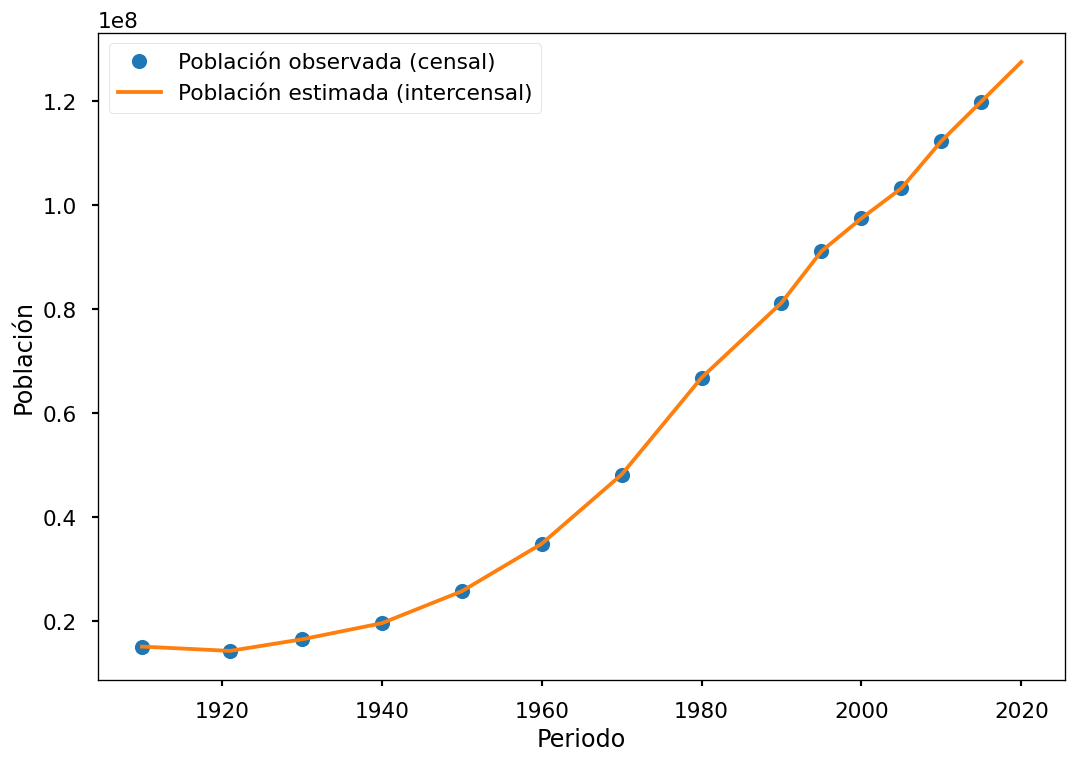

In [7]:
plt.plot(poblacion['poblacion'], 'o')
plt.plot(poblacion_estimada['poblacion'])
plt.legend(loc = 0, labels = ['Población observada (censal)', 'Población estimada (intercensal)'])
plt.xlabel('Periodo')
plt.ylabel('Población')

Finalmente podemos calcular el PIB real per cápita:

In [8]:
# Unir los datos de población estimada a los del PIB anual
pib_anual = pd.merge(pib_anual, poblacion_estimada, how='inner', on='periodo')

# Calcular PIB anual per cápita y convertirlo de millones a miles:
pib_anual['per_capita'] = (pib_anual['pib'] / pib_anual['poblacion']) * 1000

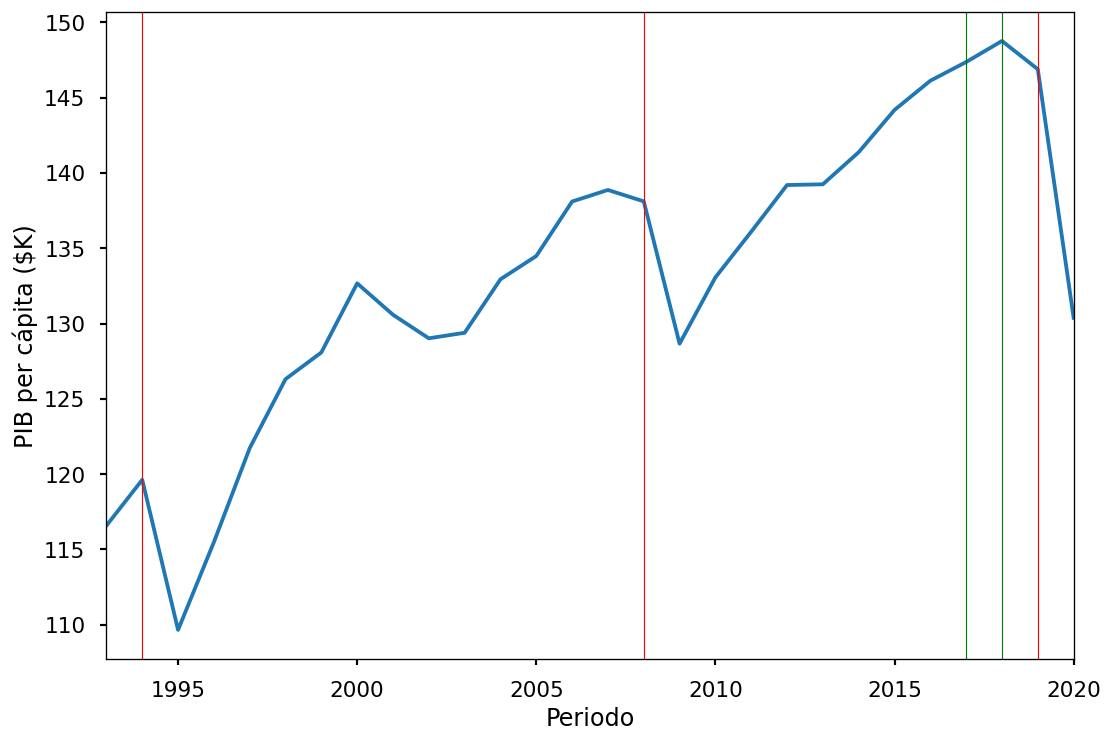

In [9]:
plt.plot(pib_anual['per_capita'])
plt.xlabel('Periodo')
plt.ylabel('PIB per cápita ($K)')
plt.xlim(min(pib_anual.index),max(pib_anual.index))
plt.axvline(x = 1994, linewidth = '0.7', color = 'r') # 1994
plt.axvline(x = 2008, linewidth = '0.7', color = 'r') # 2008
plt.axvline(x = 2019, linewidth = '0.7', color = 'r') # 2019
plt.axvline(x = 2017, linewidth = '0.7', color = 'g') # Donald Trump (2017)
plt.axvline(x = 2018, linewidth = '0.7', color = 'g') # López Obrador (2018)

Observamos que en este gráfico aparece una nueva ligera recesión en el año 2000, que corresponde al efecto conjunto de la crisis punto com y un aumento moderado en la tasa de natalidad.

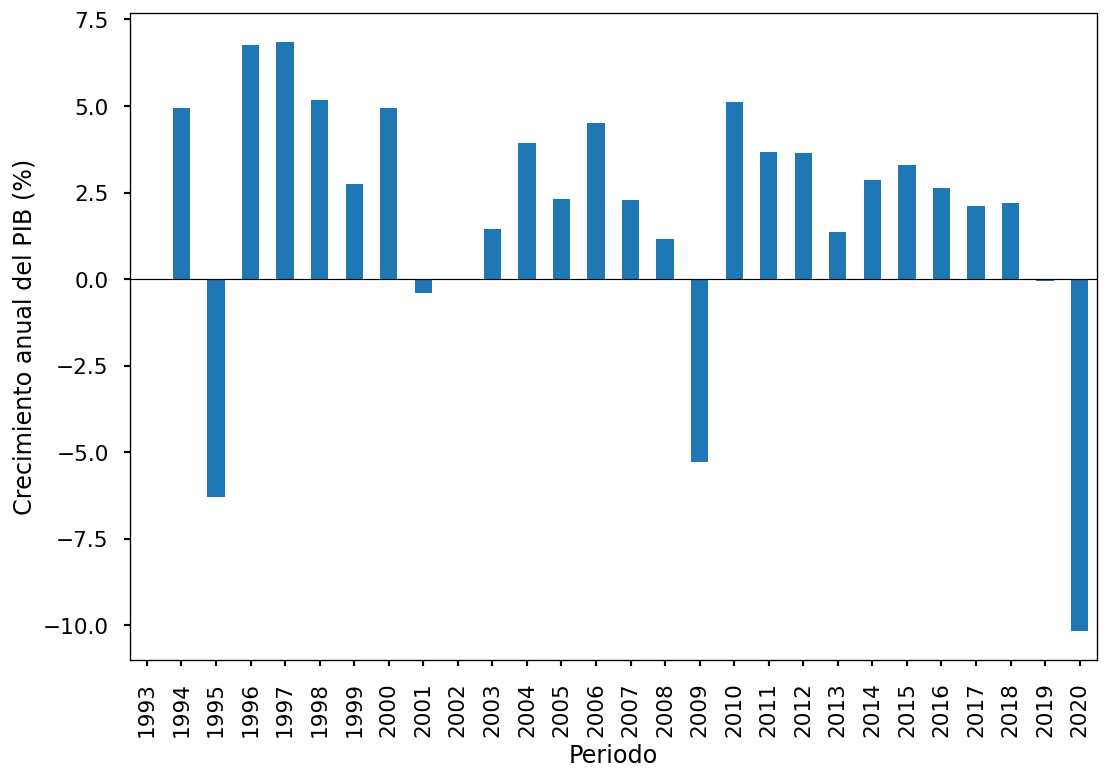

In [10]:
# Tasa de crecimiento del PIB anual:
pib_anual['pib_tasa'] = 100 * (pib_anual['pib'] - pib_anual['pib'].shift(1)) / pib_anual['pib'].shift(1)
pib_anual['pib_tasa'].plot.bar()
plt.xlabel('Periodo')
plt.ylabel('Crecimiento anual del PIB (%)')
plt.axhline(y = 0, linewidth = '0.7', color = 'k')

En esta gráfica podemos apreciar la magnitud de los decrecimientos: la crisis del coronavirus ha provocado un descenso del 10% anual en el PIB en 2020, prácticamente el doble que en las crisis anteriores.

In [11]:
# Tasa de crecimiento del PIB trimestral:
pib_trimestral['pib_tasa'] = 100 * (pib_trimestral['pib'] - pib_trimestral['pib'].shift(4)) / pib_trimestral['pib'].shift(4)
pib_trimestral['pib_tasa_continua'] = 100 * (pib_trimestral['pib'] - pib_trimestral['pib'].shift(1)) / pib_trimestral['pib'].shift(1)

# Datos en formato largo
pib_trimestral_l = pib_trimestral.copy()
pib_trimestral_l = pib_trimestral_l.pivot(columns = 'trimestre', values = ['pib', 'pib_tasa', 'pib_tasa_continua'])

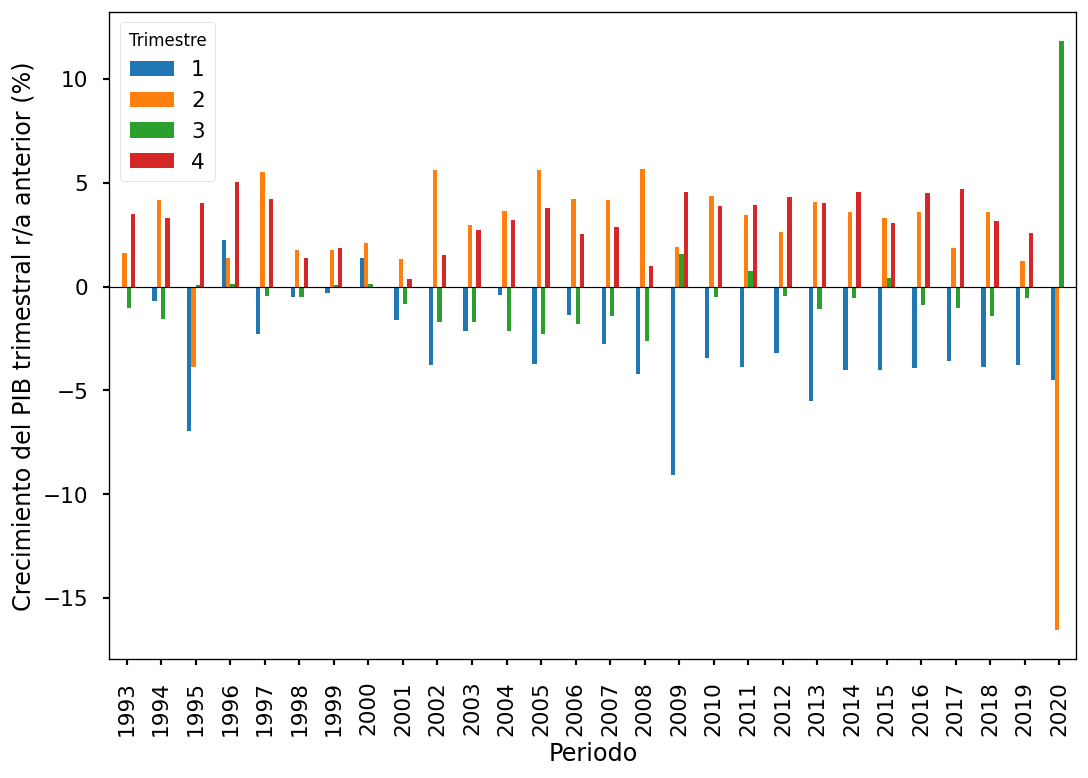

In [12]:
pib_trimestral_l['pib_tasa_continua'].plot.bar()
plt.xlabel('Periodo')
plt.ylabel('Crecimiento del PIB trimestral r/a anterior (%)')
plt.axhline(y = 0, linewidth = '0.7', color = 'k')
plt.legend(title = 'Trimestre', loc = 0)

Si bien el producto continúa en niveles bajos, observamos que el tercer trimestre de 2020 hubo un crecimiento del 10% respecto al segundo trimestre, lo que puede indicar el inicio de la recuperación. Sin embargo, los efectos a largo plazo pueden ser profundos.

## El producto interno bruto (por componentes)

Para un análisis más detallado, es útil considerar la descomposición del producto en sus respectivos componentes de demanda: consumo privado, gasto público, inversión (formación de capital fijo más variación de inventarios) y exportaciones netas (exportaciones menos importaciones). Para este análisis usamos la base de datos de oferta y utilización trimestral. Esta base no incluye la observación correspondiente al tercer trimestre del 2020.

In [13]:
# Cargar base de datos del PIB compuesto
pibc_trimestral = pd.read_excel('pib_comp.xlsx', engine = 'openpyxl')
pibc_trimestral = pibc_trimestral.set_index('periodo')

pibc_trimestral.head()

,trimestre,pib,importaciones,consumo,gasto,inversion,exportaciones,discrepancia
periodo,,,,,,,,
1993,1,1.000889e+07,1458413.400,6094259.456,1410454.426,2311587.205,1421049.137,229957.838
1993,2,1.017104e+07,1574506.158,6304689.609,1428916.551,2199172.511,1477720.814,335042.080
1993,3,1.006626e+07,1558216.038,6243681.365,1376521.052,2214659.705,1465345.740,324266.582
1993,4,1.041610e+07,1717843.240,6598264.978,1423995.127,2355827.803,1588555.613,167295.950
1994,1,1.034339e+07,1729058.259,6258192.612,1453656.689,2665717.344,1576502.879,118377.226


Igual que en el caso del PIB sin componer, calculamos el producto anual:

In [14]:
# Agrupar por periodo y calcular la media
pibc_anual = pibc_trimestral.copy()
pibc_anual = pibc_anual.groupby('periodo')
pibc_anual = pibc_anual.mean()

# Eliminar la columna 'trimestre' que ya no es necesaria
pibc_anual.pop('trimestre')

pibc_anual.head()

,pib,importaciones,consumo,gasto,inversion,exportaciones,discrepancia
periodo,,,,,,,
1993,1.016557e+07,1.577245e+06,6.310224e+06,1.409972e+06,2.270312e+06,1.488168e+06,264140.61250
1994,1.066786e+07,1.857120e+06,6.644794e+06,1.452318e+06,2.598265e+06,1.619055e+06,210548.39250
1995,9.996721e+06,1.561054e+06,6.254226e+06,1.436595e+06,1.785976e+06,1.946071e+06,134905.26825
1996,1.067382e+07,1.833894e+06,6.537721e+06,1.436303e+06,2.067390e+06,2.246699e+06,219606.00675
1997,1.140465e+07,2.257764e+06,7.026836e+06,1.505833e+06,2.358747e+06,2.457556e+06,313437.85300


Si el cálculo es correcto esperamos que se cumpla la identidad contable:

$$ Y = C + I + G + EX - IM + \epsilon$$

donde $Y$ es el PIB (del lado de la oferta), mientras que el lado de la demanda es la suma del consumo ($C$), la inversión ($I$), el gasto público ($G$), las exportaciones ($EX$), las importaciones ($IM$) y la llamada "discrepancia estadística" $\epsilon$. Verificamos que sea así:

In [15]:
# Obtener la suma de los componentes del lado de la demanda
oferta = pibc_anual['consumo'] + pibc_anual['inversion'] + pibc_anual['gasto'] + pibc_anual['exportaciones'] - pibc_anual['importaciones'] + pibc_anual['discrepancia']

# Obtener la diferencia entre el PIB (oferta) y la demanda, que debe ser cero:
diferencia = round(pibc_anual['pib'] - oferta)

# Diferencia máxima y mínima:
(max(diferencia), min(diferencia))

(0.0, 0.0)

Como las diferencias máxima y mínima son ambas cero, entonces todas las observaciones de la base de datos cumplen la identidad contable anterior. Por lo tanto el cálculo del PIB anual es correcto. A continuación calculamos las tasas de crecimiento del PIB y cada uno de sus componentes:

In [16]:
# Tasa de crecimiento de los componentes del PIB trimestral, respecto al trimestre del año anterior
pibc_trimestral['pib_tasa'] = (pibc_trimestral['pib'] - pibc_trimestral['pib'].shift(4)) / pibc_trimestral['pib'].shift(4)
pibc_trimestral['importaciones_tasa'] = 100 * (pibc_trimestral['importaciones'] - pibc_trimestral['importaciones'].shift(1)) / pibc_trimestral['importaciones'].shift(1)
pibc_trimestral['consumo_tasa'] = 100 * (pibc_trimestral['consumo'] - pibc_trimestral['consumo'].shift(1)) / pibc_trimestral['consumo'].shift(1)
pibc_trimestral['gasto_tasa'] = 100 * (pibc_trimestral['gasto'] - pibc_trimestral['gasto'].shift(1)) / pibc_trimestral['gasto'].shift(1)
pibc_trimestral['inversion_tasa'] = 100 * (pibc_trimestral['inversion'] - pibc_trimestral['inversion'].shift(1)) / pibc_trimestral['inversion'].shift(1)
pibc_trimestral['exportaciones_tasa'] = 100 * (pibc_trimestral['exportaciones'] - pibc_trimestral['exportaciones'].shift(1)) / pibc_trimestral['exportaciones'].shift(1)

# Datos del PIB trimestral en formato largo
pibc_trimestral_l = pibc_trimestral.copy()
pibc_trimestral_l = pibc_trimestral_l.pivot(columns = 'trimestre',
                                            values = ['pib_tasa', 'importaciones_tasa', 'consumo_tasa', 'gasto_tasa' , 'inversion_tasa', 'exportaciones_tasa'])

# Cálculo de las tasas de crecimiento de los componentes del PIB anual:
pibc_anual['importaciones_tasa'] = 100 * (pibc_anual['importaciones'] - pibc_anual['importaciones'].shift(1)) / pibc_anual['importaciones'].shift(1)
pibc_anual['consumo_tasa'] = 100 * (pibc_anual['consumo'] - pibc_anual['consumo'].shift(1)) / pibc_anual['consumo'].shift(1)
pibc_anual['gasto_tasa'] = 100 * (pibc_anual['gasto'] - pibc_anual['gasto'].shift(1)) / pibc_anual['gasto'].shift(1)
pibc_anual['inversion_tasa'] = 100 * (pibc_anual['inversion'] - pibc_anual['inversion'].shift(1)) / pibc_anual['inversion'].shift(1)
pibc_anual['exportaciones_tasa'] = 100 * (pibc_anual['exportaciones'] - pibc_anual['exportaciones'].shift(1)) / pibc_anual['exportaciones'].shift(1)

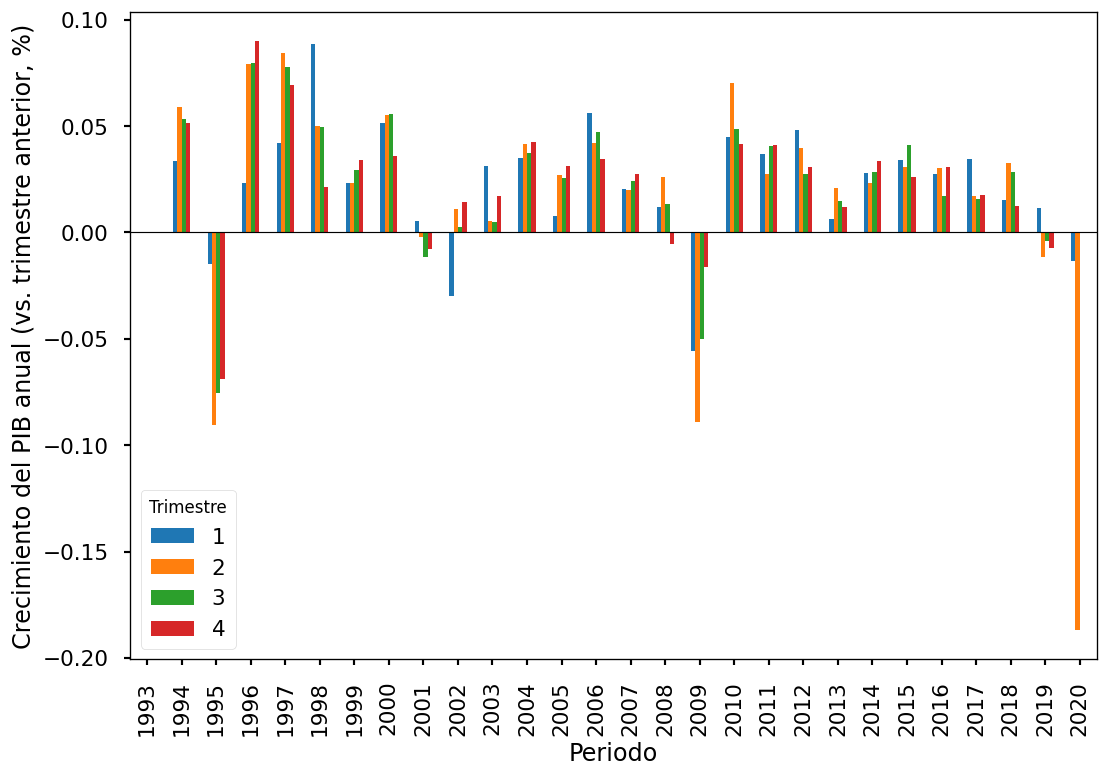

In [17]:
pibc_trimestral_l['pib_tasa'].plot.bar()
plt.xlabel('Periodo')
plt.ylabel('Crecimiento del PIB anual (vs. trimestre anterior, %)')
plt.legend(title = 'Trimestre', loc = 0)
plt.axhline(y = 0, linewidth = '0.7', color = 'k')

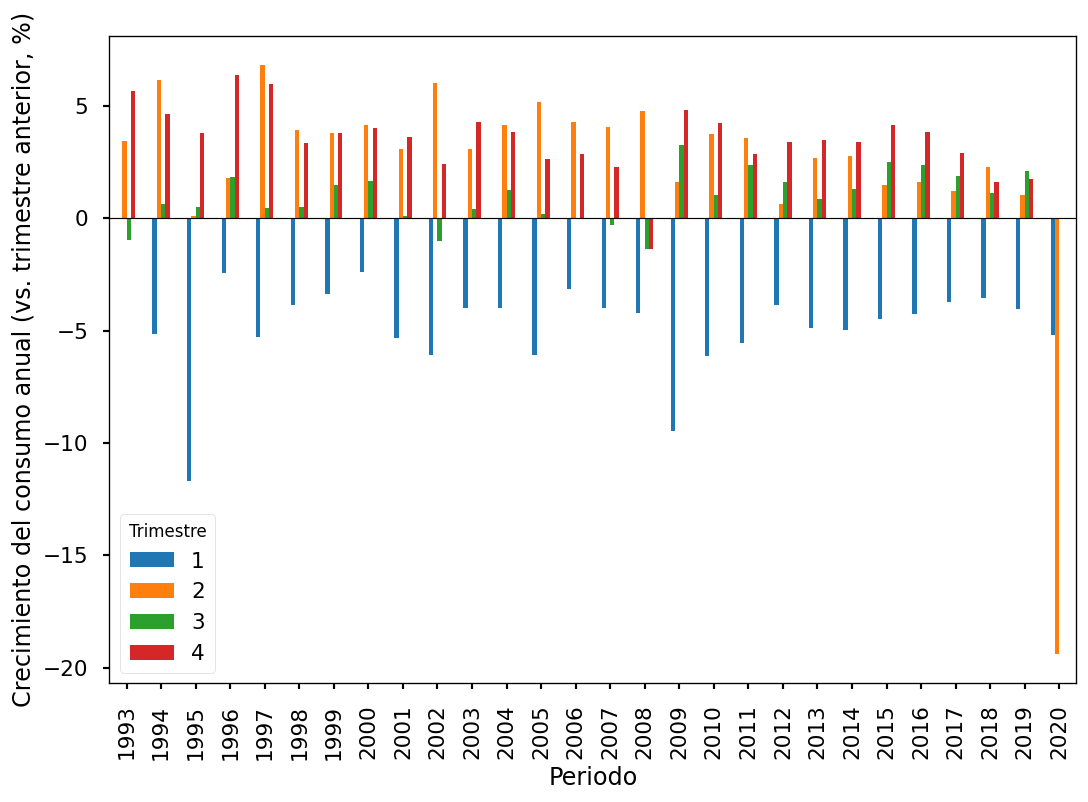

In [18]:
pibc_trimestral_l['consumo_tasa'].plot.bar()
plt.xlabel('Periodo')
plt.ylabel('Crecimiento del consumo anual (vs. trimestre anterior, %)')
plt.legend(title = 'Trimestre', loc = 0)
plt.axhline(y = 0, linewidth = '0.7', color = 'k')

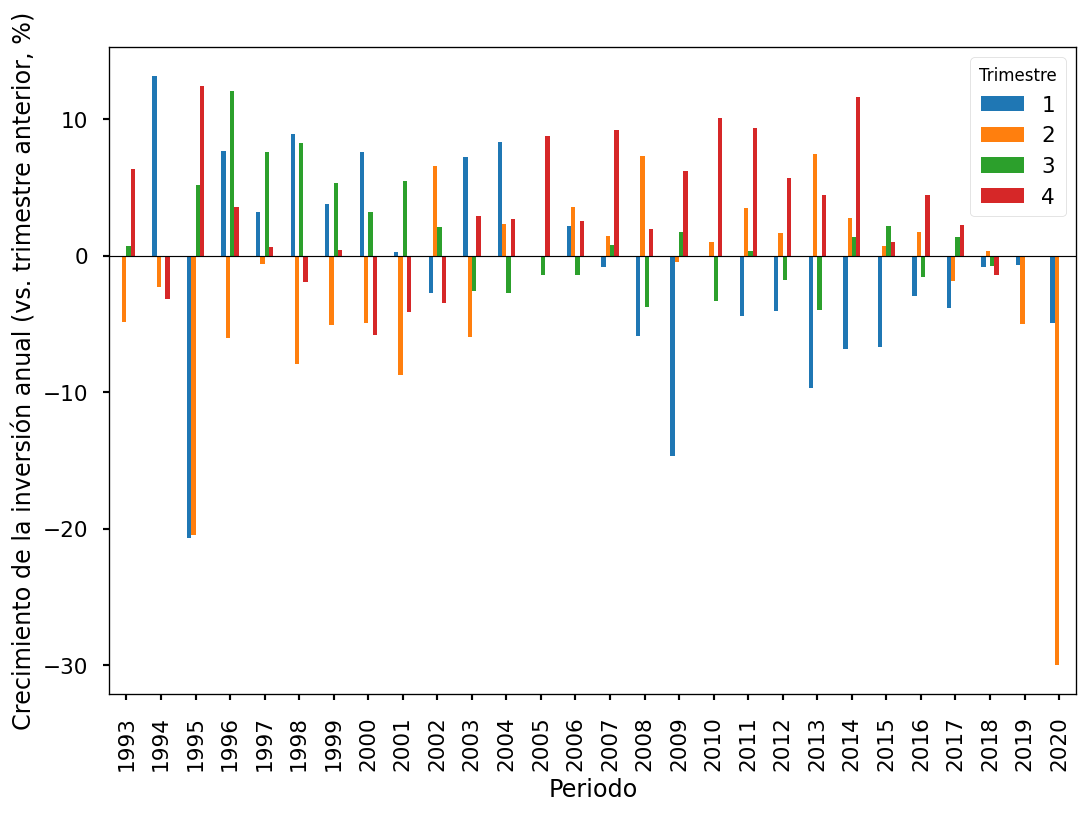

In [19]:
pibc_trimestral_l['inversion_tasa'].plot.bar()
plt.xlabel('Periodo')
plt.ylabel('Crecimiento de la inversión anual (vs. trimestre anterior, %)')
plt.legend(title = 'Trimestre', loc = 0)
plt.axhline(y = 0, linewidth = '0.7', color = 'k')

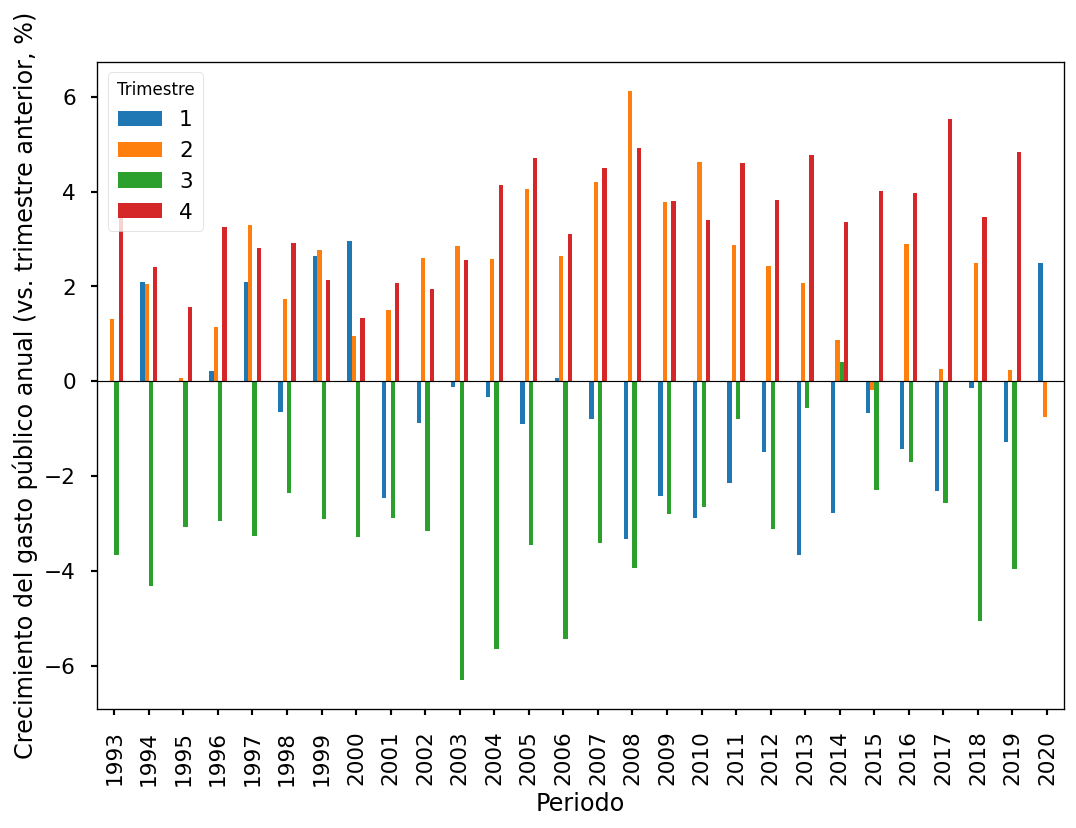

In [20]:
pibc_trimestral_l['gasto_tasa'].plot.bar()
plt.xlabel('Periodo')
plt.ylabel('Crecimiento del gasto público anual (vs. trimestre anterior, %)')
plt.legend(title = 'Trimestre', loc = 0)
plt.axhline(y = 0, linewidth = '0.7', color = 'k')

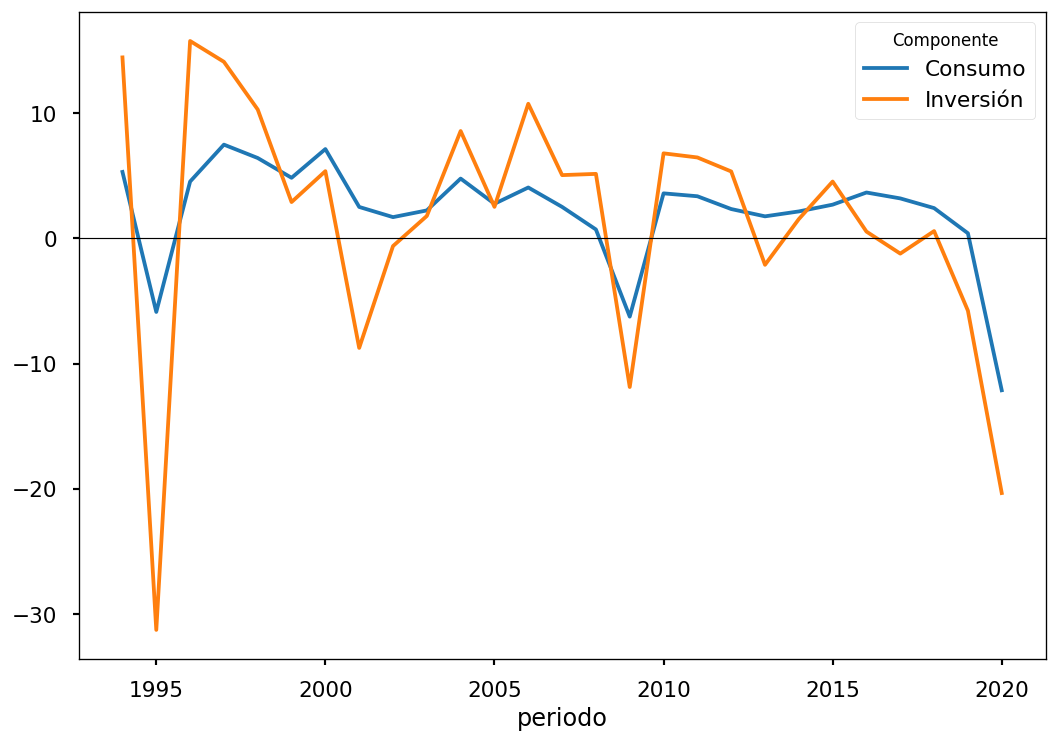

In [21]:
pibc_anual[['consumo_tasa', 'inversion_tasa']].plot()
plt.legend(title = 'Componente', loc = 0, labels = ['Consumo', 'Inversión'])
plt.axhline(y = 0, linewidth = '0.7', color = 'k')

## Desempleo

El primer objetivo consiste en buscar una relación análoga a la ley de Okun: tratamos de verificar si en México se observa una correlación negativa entre el producto y el nivel de desempleo. Las bases de datos proceden de la ENOE. El primer paso será expresar las tasas de desempleo (que se encuentran de forma mensual) como tasas trimestrales, para compararlas con la serie del PIB trimestral.

In [22]:
# Cargar base de datos de desocupación (desempleo)
desempleo = pd.read_excel('desocupacion.xlsx', engine = 'openpyxl')

desempleo.head()

,periodo,mes,desocupacion
0,2005,1,3.951998
1,2005,2,3.773302
2,2005,3,3.627075
3,2005,4,3.363412
4,2005,5,3.303693


In [23]:
# Función para convertir de mes a trimestre
def mes_a_trimestre(fila):
    if fila['mes'] in (1, 2, 3):
        return 1
    elif fila['mes'] in (4, 5, 6):
        return 2
    elif fila['mes'] in (7, 8, 9):
        return 3
    elif fila['mes'] in (10, 11, 12):
        return 4
    else:
        return 0

# Insertar columna con el trimestre
desempleo['trimestre'] = desempleo.apply(mes_a_trimestre, axis = 1)

# Calcular la tasa media de desempleo por trimestre
periodo_i = min(desempleo['periodo'])
periodo_f = max(desempleo['periodo'])

periodos = []
trimestres = []
tasas = []

for periodo in range(periodo_i, periodo_f + 1):
    trimestre_i = min(desempleo.query(f'periodo == {periodo}')['trimestre'])
    trimestre_f = max(desempleo.query(f'periodo == {periodo}')['trimestre'])
    for trimestre in range(trimestre_i, trimestre_f + 1):
        periodos.append(periodo)
        trimestres.append(trimestre)
        tasas.append(np.mean(desempleo.query(f'periodo == {periodo} & trimestre == {trimestre}')['desocupacion']))

# Guardar en un data frame nuevo
desempleo_trimestral = pd.DataFrame({'periodo': periodos, 'trimestre': trimestres, 'desocupacion': tasas})
desempleo_trimestral = desempleo_trimestral.set_index('periodo')

# Calcular tasas de cambio de la tasa de desempleo
desempleo_trimestral['desocupacion_tasa'] = 100 * (desempleo_trimestral['desocupacion'] - desempleo_trimestral['desocupacion'].shift(4)) / desempleo_trimestral['desocupacion'].shift(4)
desempleo_trimestral['desocupacion_tasa_continua'] = 100 * (desempleo_trimestral['desocupacion'] - desempleo_trimestral['desocupacion'].shift(1)) / desempleo_trimestral['desocupacion'].shift(1)

# Nuevo data frame con la información del PIB y el desempleo
mexico = pd.merge(desempleo_trimestral, pib_trimestral, how = 'inner', on = ['periodo', 'trimestre'])
mexico = mexico.set_index('trimestre', append = True)

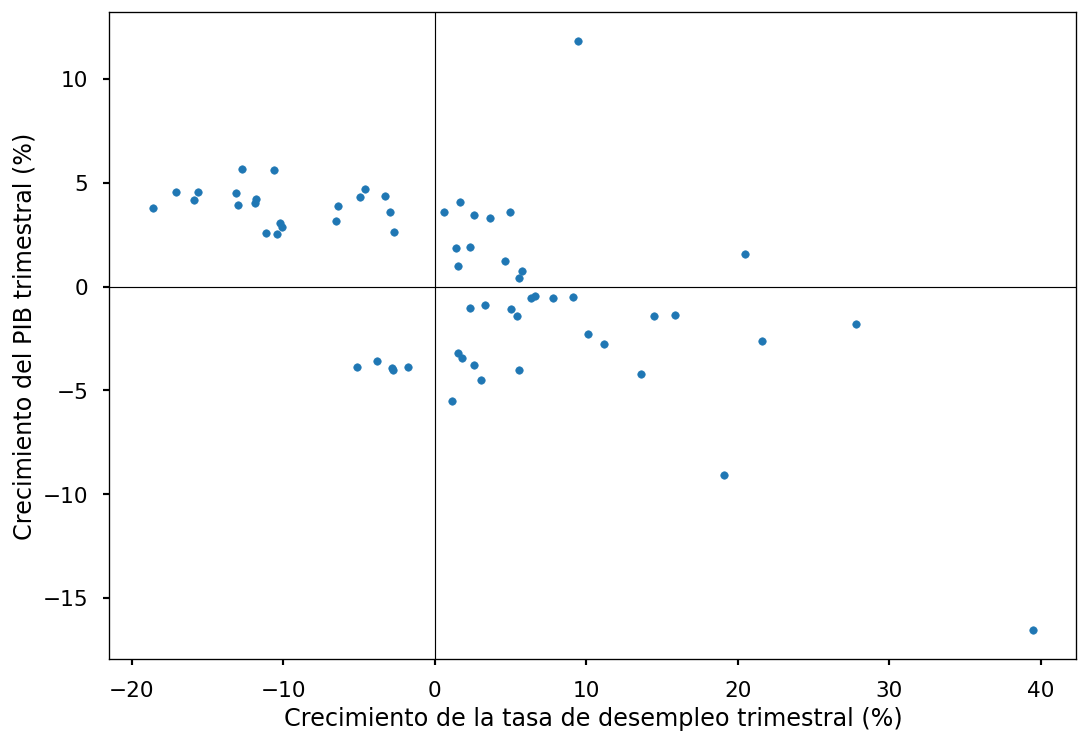

In [24]:
mexico.plot.scatter(x = 'desocupacion_tasa_continua', y = 'pib_tasa_continua')
plt.xlabel('Crecimiento de la tasa de desempleo trimestral (%)')
plt.ylabel('Crecimiento del PIB trimestral (%)')
plt.axhline(y = 0, linewidth = '0.7', color = 'k')
plt.axvline(x = 0, linewidth = '0.7', color = 'k')

La mayor densidad de puntos en los cuadrantes I y III indica una relación negativa, (no necesariamente lineal ni perfectamente continua) entre el PIB y el desempleo. Esta es la llamada "ley de Okun".

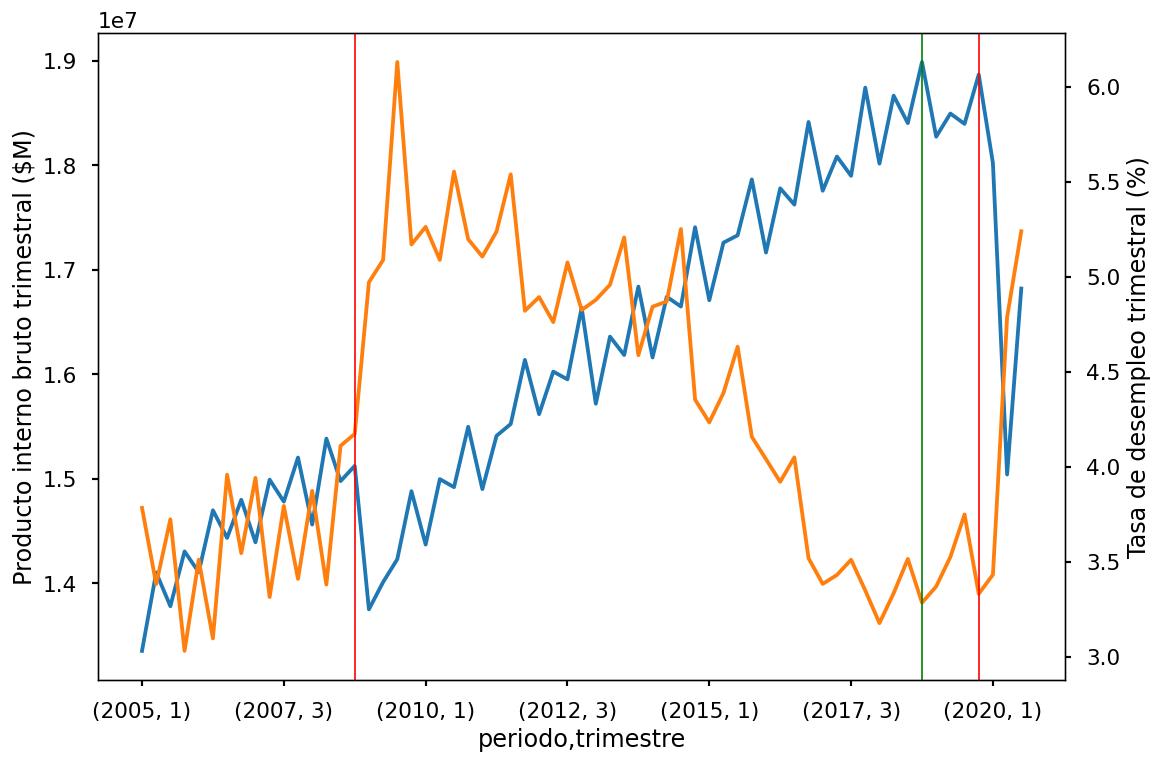

In [25]:
mexico['pib'].plot()
plt.ylabel('Producto interno bruto trimestral ($M)')
mexico['desocupacion'].plot(secondary_y = True)
plt.ylabel('Tasa de desempleo trimestral (%)')
plt.axvline(x = mexico.index.get_loc((2008,4)), linewidth = '1.0', color = 'r') # 2008
plt.axvline(x = mexico.index.get_loc((2019,4)), linewidth = '1.0', color = 'r') # 2019
plt.axvline(x = mexico.index.get_loc((2018,4)), linewidth = '1.0', color = 'g') # López Obrador (2018)

**Observaciones**
* Las crisis de 2008 y 2019 muestran elevaciones muy significativas en el nivel de desempleo.
* La tasa de desempleo se encontraba descendiendo desde su nivel máximo en el tercer trimestre de 2009 (6%) hasta el inicio del año 2020, donde creció de un nivel debajo del 3.5% a ubicarse encima del 5%.
* Los datos de la ENOE están disponibles hasta octubre de 2020, por lo que no conocemos aún la tasa de desempleo de los últimos dos meses del año.

## Pobreza

In [37]:
# Cargar base de datos del CONEVAL (desempleo)
pobreza = pd.read_excel('pobreza.xlsx', engine = 'openpyxl')
pobreza = pobreza.set_index('periodo')

pobreza.head()

,pobreza_p,pobreza,pobrezam_p,pobrezam,pobrezae_p,pobrezae,rezago_p,rezago,salud_p,salud,ss_p,ss,vivienda_p,vivienda,servicios_p,servicios,alimentacion_p,alimentacion
periodo,,,,,,,,,,,,,,,,,,
2008,44.358084,49.489496,33.308179,37.161320,11.049906,12.328176,21.946353,24.485141,38.400743,42.843000,65.000235,72.519562,17.695981,19.743079,22.857236,25.501396,21.743344,24.258647
2010,46.109093,52.813020,34.790102,39.848330,11.318991,12.964690,20.666715,23.671505,29.228195,33.477762,60.739960,69.571109,15.175357,17.381744,22.929475,26.263254,24.829697,28.439754
2012,45.479203,53.349902,35.651116,41.820952,9.828087,11.528950,19.238883,22.568393,21.540548,25.268388,61.234795,71.832181,13.550899,15.896038,21.210657,24.881405,23.316949,27.352215
2014,46.167538,55.341556,36.622036,43.899253,9.545503,11.442303,18.659902,22.367838,18.157083,21.765103,58.472368,70.091496,12.316464,14.763886,21.217252,25.433363,23.350738,27.990796
2016,43.558049,53.418151,35.913044,44.042570,7.645005,9.375581,17.387457,21.323403,15.539962,19.057696,55.799524,68.430692,12.048767,14.776209,19.309408,23.680419,20.054446,24.594110


In [38]:
# Unir data frames de pobreza y PIB anual
pobreza = pd.merge(pobreza, pib_anual, how = 'inner', on = 'periodo')

Text(0, 0.5, 'Producto interno bruto anual ($M)')

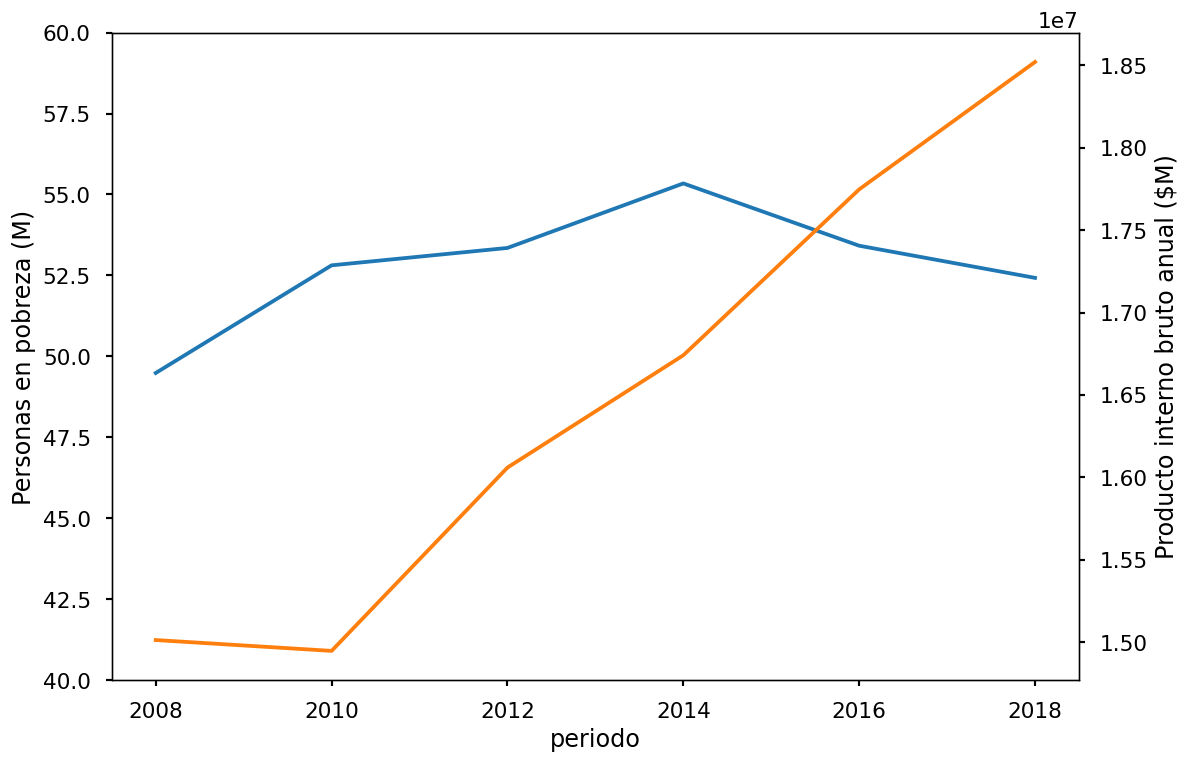

In [58]:
pobreza['pobreza'].plot(ylim = (40, 60))
plt.ylabel('Personas en pobreza (M)')
pobreza['pib'].plot(secondary_y = True)
plt.ylabel('Producto interno bruto anual ($M)')

Observamos que no hay relación aparente entre el PIB y la cantidad de personas pobres.

Text(0, 0.5, 'Producto interno bruto anual per cápita ($K)')

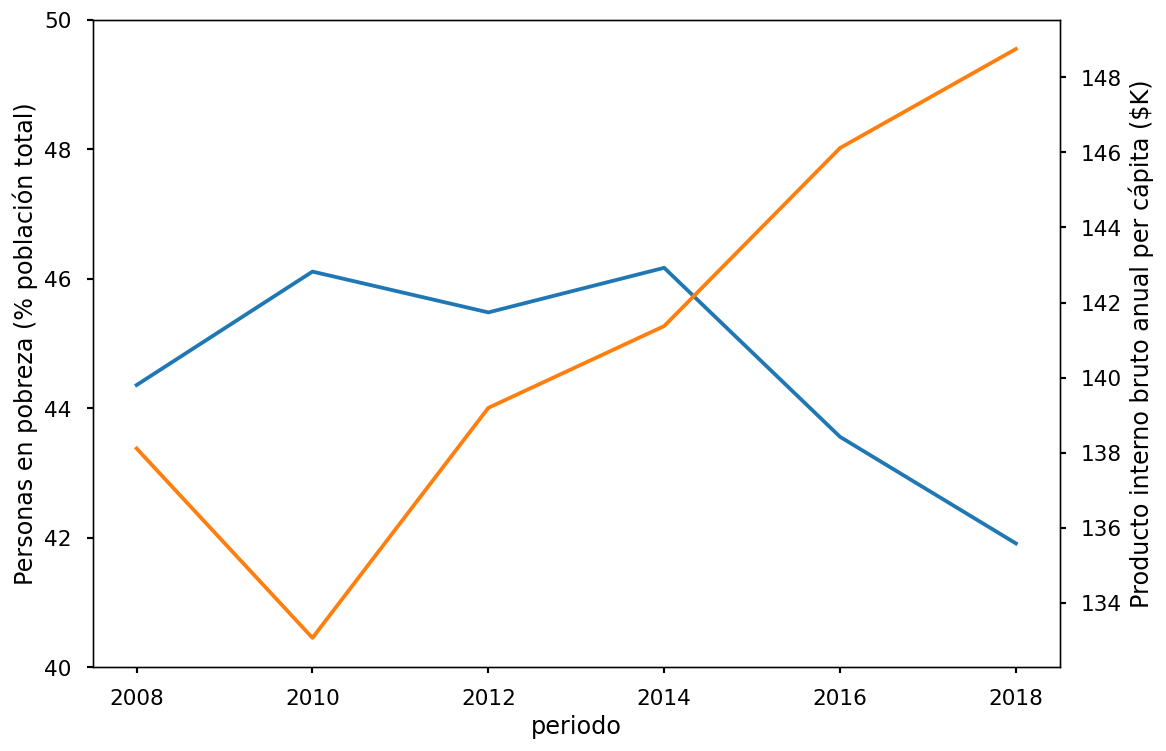

In [200]:
pobreza['pobreza_p'].plot(ylim = (40, 50))
plt.ylabel('Personas en pobreza (% población total)')
pobreza['per_capita'].plot(secondary_y = True)
plt.ylabel('Producto interno bruto anual per cápita ($K)')

Al corregir por el tamaño de la población, la relación negativa entre PIB y pobreza se vuelve más aparente.

<AxesSubplot:xlabel='per_capita', ylabel='pobreza_p'>

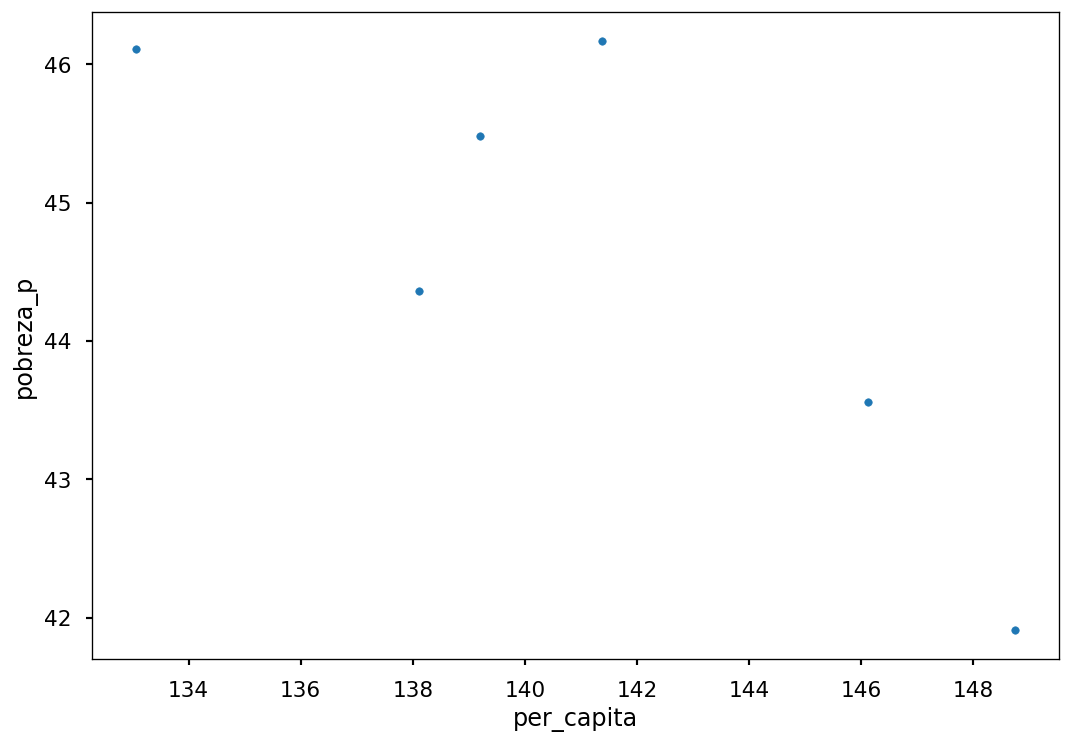

In [60]:
pobreza.plot.scatter(x = 'per_capita', y = 'pobreza_p')

In [68]:
# Ajustar modelo de regresión del porcentaje de población en pobreza sobre el PIB per cápita
modelo_pobreza = smf.ols('pobreza_p ~ per_capita', data = pobreza)
modelo_pobreza = modelo_pobreza.fit()

print(modelo_pobreza.summary())

                            OLS Regression Results                            
Dep. Variable:              pobreza_p   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     7.834
Date:                Fri, 01 Jan 2021   Prob (F-statistic):             0.0489
Time:                        17:26:55   Log-Likelihood:                -7.7739
No. Observations:                   6   AIC:                             19.55
Df Residuals:                       4   BIC:                             19.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     78.2917     12.047      6.499      0.0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


In [209]:
pobreza['pobreza_p']

periodo
2008    44.358084
2010    46.109093
2012    45.479203
2014    46.167538
2016    43.558049
2018    41.913075
Name: pobreza_p, dtype: float64

In [162]:
# Nuevo data frame para proyección de pobreza en 2020
pobreza_ext = pobreza.copy()
pobreza_ext = pobreza_ext[['pobreza_p', 'per_capita']]

# Proyección de pobreza para 2020
pib_2020 = pib_anual.query('periodo == 2020')['per_capita'][2020]
pobreza_2020 = modelo_pobreza.params['per_capita'] * pib_2020 + modelo_pobreza.params['Intercept']

# Añadir al data frame
pobreza_ext = pobreza_ext.append(pd.DataFrame({'per_capita': {2020: pib_2020}, 'pobreza_p': {2020: pobreza_2020}}))
pobreza_ext.loc[:2018]

,pobreza_p,per_capita
2008,44.358084,138.110143
2010,46.109093,133.062626
2012,45.479203,139.193082
2014,46.167538,141.372408
2016,43.558049,146.117288
2018,41.913075,148.755807


Text(0, 0.5, 'Producto interno bruto anual per cápita ($K)')

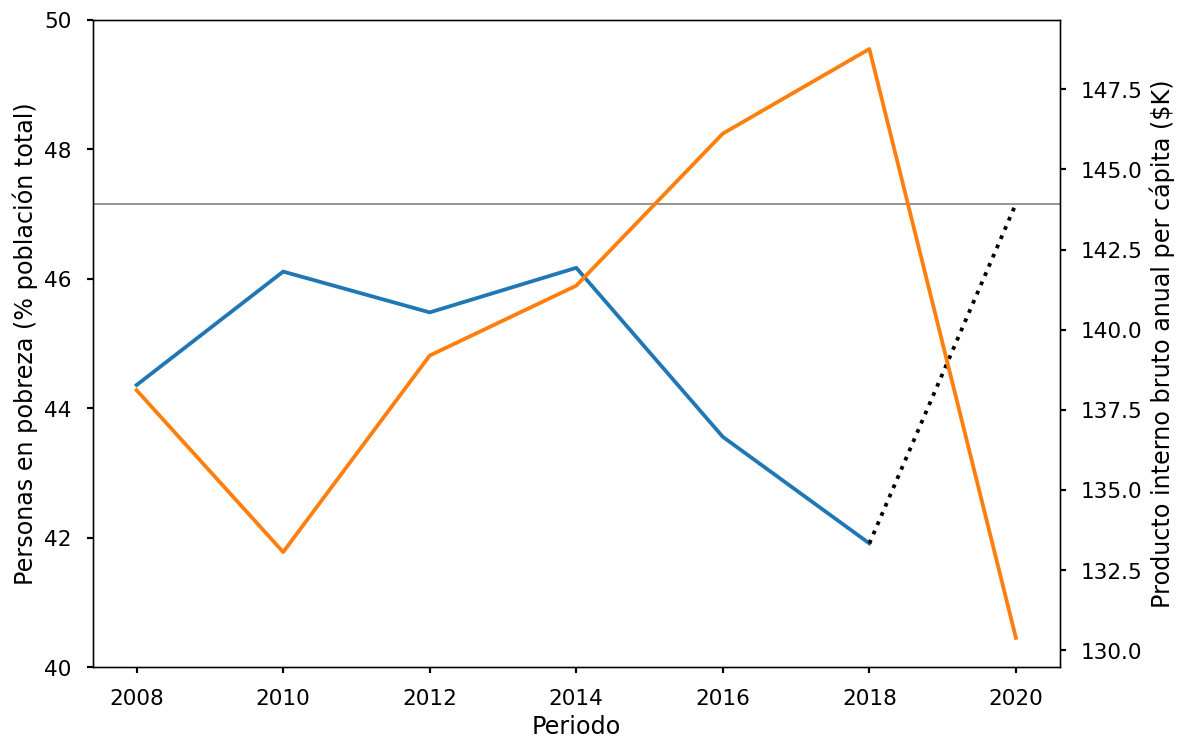

In [206]:
pobreza_ext.loc[:2018]['pobreza_p'].plot(ylim = (40, 50))
pobreza_ext.loc[2018:2020]['pobreza_p'].plot(ylim = (40, 50), style = ":k")
plt.axhline(y = pobreza_2020, linewidth = '1.0', color = 'grey')
plt.xlabel('Periodo')
plt.ylabel('Personas en pobreza (% población total)')
pobreza_ext['per_capita'].plot(secondary_y = True)
plt.ylabel('Producto interno bruto anual per cápita ($K)')